In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'oliverkim3083' # username
os.environ['KAGGLE_KEY'] = '63186cfe3528c7ff36943d6b10438886' # key

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

 97% 336M/346M [00:02<00:00, 164MB/s]
100% 346M/346M [00:02<00:00, 133MB/s]


In [4]:
# 라이브러리 import
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [5]:
# 이미지 데이터 Argumentation 세팅 후 train, test 데이터 불러오고 자동으로 labeling함
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory( # 이미지 데이터를 폴더에서 알아서 읽어옴 + 폴더에 따라 label을 하고 class에 따라서 분류도 해줌
  'seg_train/seg_train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical', # label이 여러개이면 categorical, 2개이면 binary
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'seg_test/seg_test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
# one-hot-encoding으로 class가 어떻게 분류되었는지 확인
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


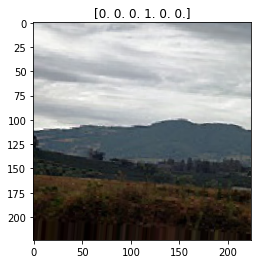

In [7]:
# 이미지를 불러와 one-hot-encoding으로 표현
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

In [8]:
# ResNet50을 불러와서 전이학습 후 모델 확인
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max') # include_top = 출력 갯수 동일하게 할거냐 False이므로 X

x = base_model.output
x1 = Dropout(rate=0.25)(x)
x2 = Dense(256, activation='relu')(x1)
output = Dense(6, activation='softmax')(x2)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
# 신경망 모델을 epochs 20으로 학습 후 모델 저장
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True) # monitor='val_acc', save_best_only=True : 여러개 중 val,acc가 가장 좋은 것 하나만을 저장
    ]
)

Epoch 1/20
439/439 [==============================] - 247s 477ms/step - loss: 0.9224 - acc: 0.7735 - val_loss: 2.2469 - val_acc: 0.1750

Epoch 00001: val_acc improved from -inf to 0.17500, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
439/439 [==============================] - 209s 476ms/step - loss: 0.3982 - acc: 0.8650 - val_loss: 0.8437 - val_acc: 0.7017

Epoch 00002: val_acc improved from 0.17500 to 0.70167, saving model to model.h5
Epoch 3/20
439/439 [==============================] - 208s 473ms/step - loss: 0.3605 - acc: 0.8755 - val_loss: 0.4067 - val_acc: 0.8590

Epoch 00003: val_acc improved from 0.70167 to 0.85900, saving model to model.h5
Epoch 4/20
439/439 [==============================] - 208s 473ms/step - loss: 0.3330 - acc: 0.8853 - val_loss: 0.5322 - val_acc: 0.8153

Epoch 00004: val_acc did not improve from 0.85900
Epoch 5/20
439/439 [==============================] - 207s 472ms/step - loss: 0.3188 - acc: 0.8881 - val_loss: 0.4951 - val_acc: 0.8277

Epoch 00005: val_acc did not improve from 0.85900
Epoch 6/20
439/439 [==============================] - 208s 472ms/step - loss: 0.3068 - acc: 0.8944 - val_loss: 0.4281 - val_acc: 0.8380

Epoch 00006: val_acc did not improve from 0.85900
Epoch

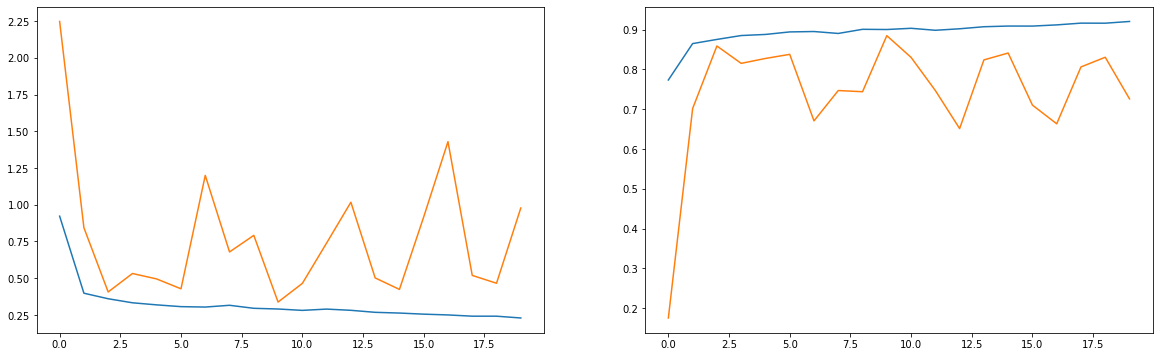

In [10]:
# 잘 학습이 되었는지 그래프로 확인
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

In [11]:
# 저장한 모델 불러오기
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


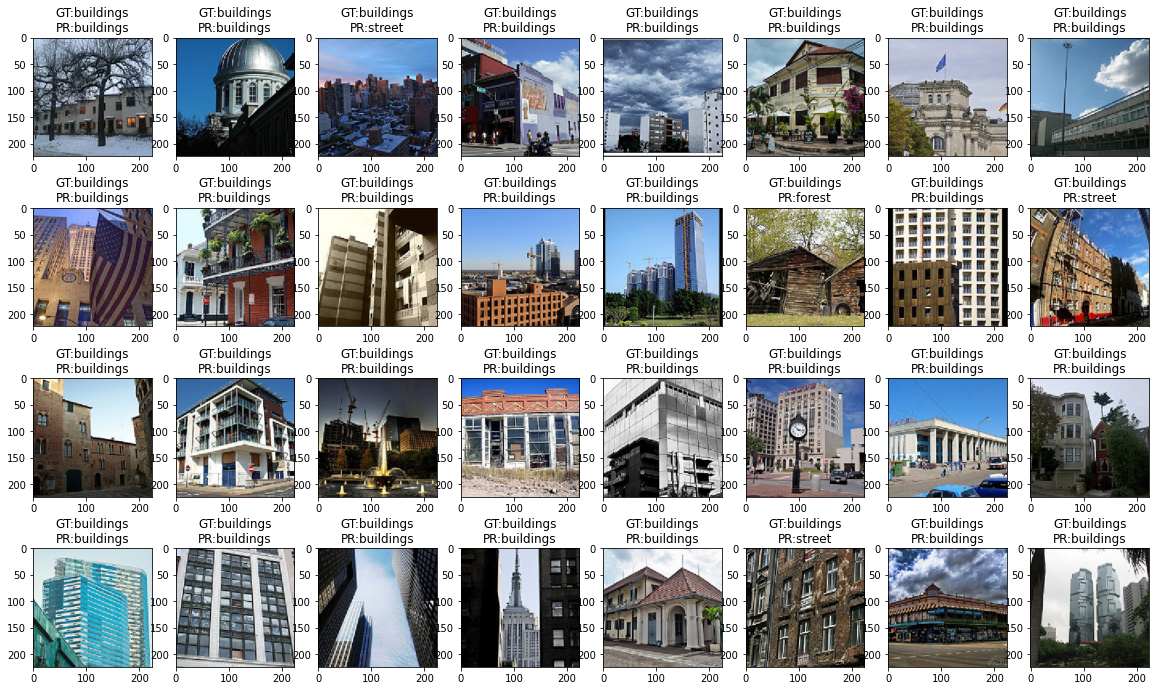

In [13]:
# 테스트 이미지를 통하여 잘 학습 되었는지 확인
test_imgs, test_labels = test_gen.__getitem__(10)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)] # np.argmax로 가장 큰 값의 index를 뽑아 : one-hot-encoding한 것을 class로 돌려줌
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label)) # GT(Ground Truth, 정답값), PR(Prediction, 예측값)
  ax.imshow(img)